<a href="https://colab.research.google.com/github/chokkan/deeplearning/blob/master/notebook/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Networks for structual input



## Download the dataset

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip

--2019-07-22 15:58:09--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.80.22, 13.32.80.66, 13.32.80.97, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.80.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  15.6MB/s    in 0.2s    

2019-07-22 15:58:09 (15.6 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [3]:
!cat data/names/Russian.txt

Ababko
Abaev
Abagyan
Abaidulin
Abaidullin
Abaimoff
Abaimov
Abakeliya
Abakovsky
Abakshin
Abakumoff
Abakumov
Abakumtsev
Abakushin
Abalakin
Abalakoff
Abalakov
Abaleshev
Abalihin
Abalikhin
Abalkin
Abalmasoff
Abalmasov
Abaloff
Abalov
Abamelek
Abanin
Abankin
Abarinoff
Abarinov
Abasheev
Abashev
Abashidze
Abashin
Abashkin
Abasov
Abatsiev
Abaturoff
Abaturov
Abaza
Abaziev
Abbakumov
Abbakumovsky
Abbasov
Abdank-Kossovsky
Abdeev
Abdildin
Abdrahimoff
Abdrahimov
Abdrahmanoff
Abdrahmanov
Abdrakhimoff
Abdrakhimov
Abdrakhmanoff
Abdrakhmanov
Abdrashitoff
Abdrashitov
Abdrazakoff
Abdrazakov
Abdulaev
Abdulatipoff
Abdulatipov
Abdulazizoff
Abdulazizov
Abdulbasiroff
Abdulbasirov
Abdulbekoff
Abdulbekov
Abdulgapuroff
Abdulgapurov
Abdulgaziev
Abdulhabiroff
Abdulhabirov
Abdulin
Abdulkadyroff
Abdulkadyrov
Abdulkhabiroff
Abdulkhabirov
Abdulladjanov
Abdulladzhanoff
Abdulladzhanov
Abdullaev
Abdullin
Abduloff
Abdulov
Abdulrahmanoff
Abdulrahmanov
Abdulrakhmanoff
Abdulrakhmanov
Abdurahmanoff
Abdurahmanov
Abdurakhmanoff
A

## Normalize name spellings in the dataset

In [0]:
import string
import unicodedata

# Alphabet [a-zA-Z .,;']
alphabet = set(string.ascii_letters + " .,;'")

def normalize(s):
    # Apply canonical decomposition, and ignore non-alphabet symbols.
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) if c in alphabet
        )

In [5]:
normalize('Ślusàrski')

'Slusarski'

In [0]:
import glob
import json
import os

data = []
srcs = glob.glob('data/names/*.txt')
for src in srcs:
    lang = os.path.basename(src)[:-4]
    for line in open(src):
        line = line.strip('\n')
        data.append((normalize(line), lang))
    
with open('names.json', 'w') as fo:
    json.dump(data, fo)

In [7]:
!cat names.json

[["Aalsburg", "Dutch"], ["Aalst", "Dutch"], ["Aarle", "Dutch"], ["Achteren", "Dutch"], ["Achthoven", "Dutch"], ["Adrichem", "Dutch"], ["Aggelen", "Dutch"], ["Agteren", "Dutch"], ["Agthoven", "Dutch"], ["Akkeren", "Dutch"], ["Aller", "Dutch"], ["Alphen", "Dutch"], ["Alst", "Dutch"], ["Altena", "Dutch"], ["Althuis", "Dutch"], ["Amelsvoort", "Dutch"], ["Amersvoort", "Dutch"], ["Amstel", "Dutch"], ["Andel", "Dutch"], ["Andringa", "Dutch"], ["Ankeren", "Dutch"], ["Antwerp", "Dutch"], ["Antwerpen", "Dutch"], ["Apeldoorn", "Dutch"], ["Arendonk", "Dutch"], ["Asch", "Dutch"], ["Assen", "Dutch"], ["Baarle", "Dutch"], ["Bokhoven", "Dutch"], ["Breda", "Dutch"], ["Bueren", "Dutch"], ["Buggenum", "Dutch"], ["Buiren", "Dutch"], ["Buren", "Dutch"], ["Can", "Dutch"], ["Cann", "Dutch"], ["Canne", "Dutch"], ["Daal", "Dutch"], ["Daalen", "Dutch"], ["Dael", "Dutch"], ["Daele", "Dutch"], ["Dale", "Dutch"], ["Dalen", "Dutch"], ["Laar", "Dutch"], ["Vliert", "Dutch"], ["Akker", "Dutch"], ["Andel", "Dutch"], ["

## Convert the string data into numerical data

In [10]:
def find_vocabulary(data):
    X, Y = set(), set()    
    for (x, y) in data:
        X.update(c for c in x)
        Y.add(y)
    return sorted(X), sorted(Y)

def build_mapping(items):
    M = {}
    for item in items:
        M.setdefault(item, len(M))
    return M

def convert_to_numeric_data(data, Xmap, Ymap):
    D = []
    for (x, y) in data:
        D.append(([Xmap[c] for c in x], Ymap[y]))
    return D    

import json
data = json.load(open('names.json'))

X, Y = find_vocabulary(data)
print(X)
print(Y)
Xmap = build_mapping(X)
Ymap = build_mapping(Y)

with open('names.data.json', 'w') as fo:
    json.dump(dict(
        data = convert_to_numeric_data(data, Xmap, Ymap),
        X = X,
        Y = Y,
        ), fo)

[' ', "'", ',', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [9]:
!cat names.data.json

{"data": [[[3, 29, 40, 47, 30, 49, 46, 35], 3], [[3, 29, 40, 47, 48], 3], [[3, 29, 46, 40, 33], 3], [[3, 31, 36, 48, 33, 46, 33, 42], 3], [[3, 31, 36, 48, 36, 43, 50, 33, 42], 3], [[3, 32, 46, 37, 31, 36, 33, 41], 3], [[3, 35, 35, 33, 40, 33, 42], 3], [[3, 35, 48, 33, 46, 33, 42], 3], [[3, 35, 48, 36, 43, 50, 33, 42], 3], [[3, 39, 39, 33, 46, 33, 42], 3], [[3, 40, 40, 33, 46], 3], [[3, 40, 44, 36, 33, 42], 3], [[3, 40, 47, 48], 3], [[3, 40, 48, 33, 42, 29], 3], [[3, 40, 48, 36, 49, 37, 47], 3], [[3, 41, 33, 40, 47, 50, 43, 43, 46, 48], 3], [[3, 41, 33, 46, 47, 50, 43, 43, 46, 48], 3], [[3, 41, 47, 48, 33, 40], 3], [[3, 42, 32, 33, 40], 3], [[3, 42, 32, 46, 37, 42, 35, 29], 3], [[3, 42, 39, 33, 46, 33, 42], 3], [[3, 42, 48, 51, 33, 46, 44], 3], [[3, 42, 48, 51, 33, 46, 44, 33, 42], 3], [[3, 44, 33, 40, 32, 43, 43, 46, 42], 3], [[3, 46, 33, 42, 32, 43, 42, 39], 3], [[3, 47, 31, 36], 3], [[3, 47, 47, 33, 42], 3], [[4, 29, 29, 46, 40, 33], 3], [[4, 43, 39, 36, 43, 50, 33, 42], 3], [[4, 46,

In [0]:
data = json.load(open('names.data.json'))

In [15]:
data['X']

[' ',
 "'",
 ',',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [16]:
data['Y']

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [17]:
data['data'][0]

[[3, 29, 40, 47, 30, 49, 46, 35], 3]

In [20]:
''.join(data['X'][i] for i in data['data'][100][0])

'Kolen'

In [21]:
data['data'][100][1]

3

In [22]:
data['Y'][data['data'][100][1]]

'Dutch'

## Install necessary modules

In [23]:
!pip install livelossplot

## Implementing RNN cells (states)

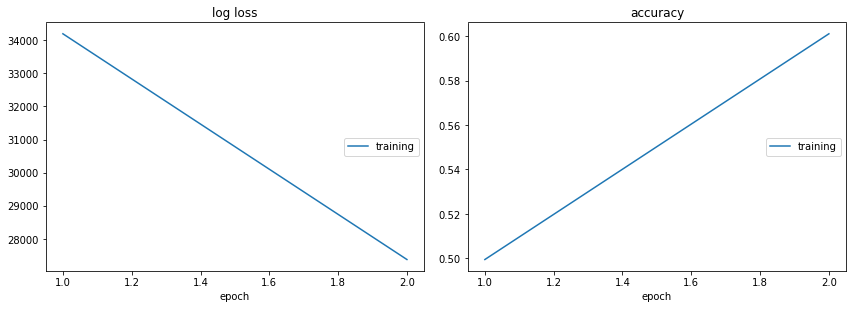

log loss:
training   (min: 27375.483, max: 34193.125, cur: 27375.483)

accuracy:
training   (min:    0.499, max:    0.601, cur:    0.601)


KeyboardInterrupt: ignored

In [24]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size
        self.f = nn.Tanh()
        self.hi = nn.Linear(input_size + hidden_size, hidden_size)
        self.oh = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        new_hidden = self.f(self.hi(torch.cat((input, hidden), 0)))
        new_output = self.oh(new_hidden)
        return new_output, new_hidden
    
    def initHidden(self):
        return torch.zeros(self.hidden_size)
    
def x_to_tensor(x, input_size):
    tensor = torch.zeros(len(x), input_size, dtype=torch.float)
    for i, j in enumerate(x):
        tensor[i][j] = 1
    return tensor

def y_to_tensor(y):
    tensor = torch.zeros(1, dtype=torch.long)
    tensor[0] = y
    return tensor

data = json.load(open('names.data.json'))
dataset = data['data']
input_size = len(data['X'])
output_size = len(data['Y'])

model = RNNCell(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(10):
    train_loss = 0.
    num_train_correct = 0
    random.shuffle(dataset)
    
    # Training loop for every instance.
    for (x, y) in dataset:
        # Convert a training instance into tensors in place.
        x = x_to_tensor(x, input_size)
        y = y_to_tensor(y)
        
        # Recurrent Neural Network
        hidden = model.initHidden()
        for xt in x:
            output, hidden = model(xt, hidden)
                
        # Make predictions with the current parameters.
        y_pred = output.view(1, -1)  # Reshape the output: (18) -> (1, 18)
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(dataset))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))

## Using `nn.RNN` module

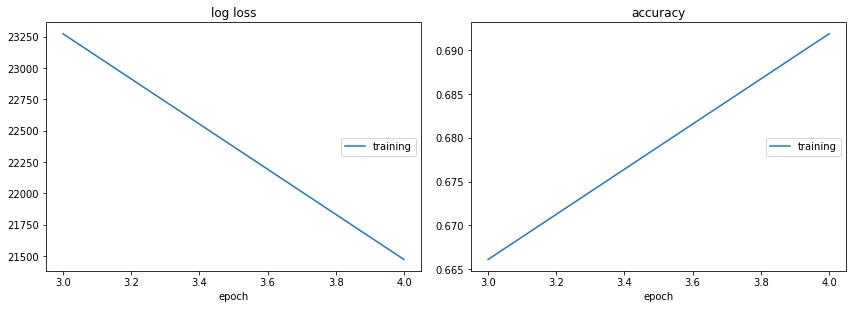

log loss:
training   (min: 21470.480, max: 32998.187, cur: 21470.480)

accuracy:
training   (min:    0.509, max:    0.692, cur:    0.692)


KeyboardInterrupt: ignored

In [25]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

class SequenceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SequenceRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output[-1])
        return output
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
def x_to_tensor(x, input_size):
    tensor = torch.zeros(len(x), 1, input_size, dtype=torch.float)
    for i, j in enumerate(x):
        tensor[i][0][j] = 1   # (T, batch, input_dim)
    return tensor

def y_to_tensor(y):
    tensor = torch.zeros(1, dtype=torch.long)
    tensor[0] = y
    return tensor

data = json.load(open('names.data.json'))
dataset = data['data']
input_size = len(data['X'])
output_size = len(data['Y'])

model = SequenceRNN(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(10):
    train_loss = 0.
    num_train_correct = 0
    random.shuffle(dataset)
    
    # Training loop for every instance.
    for (x, y) in dataset:
        # Convert a training instance into tensors in place.
        x = x_to_tensor(x, input_size)
        y = y_to_tensor(y)
        
        # Make predictions with the current parameters.
        y_pred = model(x, model.initHidden())
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(dataset))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))

### Predict a nationality of a name by using the trained model

In [0]:
def predict(name):
    x = []
    for c in name:
        x.append(data['X'].index(c))
    x = x_to_tensor(x, len(data['X']))
    hidden = model.initHidden()
    y_pred = nn.Softmax(dim=-1)(model(x, hidden))
   
    scores = []
    for index, lang in enumerate(data['Y']):
        scores.append((lang, float(y_pred[0][index])))
        
    return sorted(scores, key=lambda x: x[1], reverse=True)

In [0]:
predict('Sato')

[('Japanese', 0.5089209079742432),
 ('Italian', 0.16908761858940125),
 ('Chinese', 0.05333806201815605),
 ('Spanish', 0.038286805152893066),
 ('German', 0.03407859802246094),
 ('English', 0.0309290811419487),
 ('Russian', 0.02343100495636463),
 ('Vietnamese', 0.022395256906747818),
 ('Korean', 0.021983902901411057),
 ('Irish', 0.01956593617796898),
 ('Portuguese', 0.01605183258652687),
 ('Czech', 0.015361032448709011),
 ('Dutch', 0.012027307413518429),
 ('French', 0.011851625517010689),
 ('Scottish', 0.009969018399715424),
 ('Polish', 0.007304798811674118),
 ('Arabic', 0.004673274699598551),
 ('Greek', 0.0007438952452503145)]

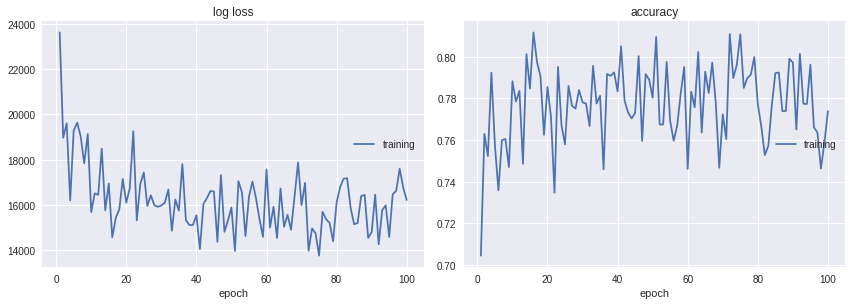

Accuracy: 0.7738 (train)


In [0]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses

class MinibatchSequenceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MinibatchSequenceRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def last_timestep(self, unpacked, lengths):
        idx = (lengths-1).view(-1, 1).expand(
            unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        return unpacked.gather(1, idx).squeeze()
    
    def forward(self, input, hidden, l):
        input = nn.utils.rnn.pack_padded_sequence(input, l, batch_first=True)
        output, hidden = self.rnn(input, hidden)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        output = self.last_timestep(output, l)
        output = self.fc(output)
        return output
    
    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)
    
def create_dataset(data, X, Y):
    # Sort the data by sequence length (long to short)
    data.sort(key=lambda instance: len(instance[0]), reverse=True)
    
    input_size = len(X)
    output_size = len(Y)
    max_length = len(data[0][0])
    num_instances = len(data)
    
    xt = torch.zeros(num_instances, max_length, input_size, dtype=torch.float)
    yt = torch.zeros(num_instances, dtype=torch.long)
    lt = torch.zeros(num_instances, dtype=torch.long)
                    
    for i, (x, y) in enumerate(data):
        for t, v in enumerate(x):
            xt[i][t][v] = 1
        yt[i] = y
        lt[i] = len(x)
    return TensorDataset(xt, yt, lt)

batch_size = 32
data = json.load(open('names.data.json'))
train_set = create_dataset(data['data'], data['X'], data['Y'])
train_loader = DataLoader(train_set, batch_size=batch_size)
input_size = len(data['X'])
output_size = len(data['Y'])

model = MinibatchSequenceRNN(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=1e-3)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    num_train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y, l) in enumerate(train_loader):
        this_batch_size = len(l)
        
        # Make predictions with the current parameters.
        hidden = model.initHidden(this_batch_size)
        y_pred = model(x, hidden, l)[:this_batch_size]
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(dataset))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))